# Logistic Regression

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns=None
pd.options.display.max_rows=None

## 알고 가야 할 것 들

### 1. Evidence of Weight
### 2. Information Value
### 3. VIF
### 4. C 통계량
### 5. AIC
### 6. ROC, AUC

## 데이터 셋을 로딩합니다.

In [2]:
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
dataset = pd.read_csv(path, delimiter=' ', header=None)

In [3]:
dataset.shape

(1000, 21)

In [4]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
COL = [
    'Status_of_existing_checking_account', 
    'Duration_in_month',
    'Credit_history',
    'Purpose', 
    'Credit_amount', 
    'Savings_account_bonds', 
    'Present_employment_since', 
    'Installment_rate_in_percentage_of_disposable_income',
    'Personal_status_and_sex',
    'Other_debtors_guarantors',
    'Present_residence_since', 
    'Property', 
    'Age_in_years', 
    'Other_installment_plans', 
    'Housing',
    'Number_of_existing_credits_at_this_bank',
    'Job',
    'Number_of_people_being_liable_to_provide_maintenance_for',
    'Telephone',
    'foreign_worker',
    'Target'
]

In [6]:
dataset.columns = COL

In [7]:
# 총 20개의 설명 변수와 1개의 종속 변수
dataset.head()

,Status_of_existing_checking_account,Duration_in_month,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_in_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,Present_residence_since,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,foreign_worker,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


Label
 - 1 : Good (갚을 수 있다 / 신용도가 좋다) $\to$ 0으로 변경
 - 2 : Bad (갚을 수 없다 / 신용도가 나쁘다) $\to$ 1로 변경

- Ham(0) / Spam(1)
- 정상사람(0) / 암환자(1)
- 이벤트가 발생하지 않음(0) / 이벤트가 발생함(1)
- 귀무가설(0) / 대립가설(1)

In [8]:
# Label을 1/2 -> 0/1로 변경
dataset['Target'] = dataset['Target'] - 1

## 1. Information Value (정보 가치)
모델에서 변수의 사용유무를 판단하는 feature selection에서 유용한 방법입니다. 주로 모델을 학습하기전 첫 단계에서 변수들을 제거하는 데 사용합니다. 최종 모델에서는 대략 10개 내외의 변수를 사용하도록 합니다. IV와 WOE 신용채무능력이 가능한(good) 고객과 불가능한(bad) 고객을 예측하는 로지스틱 회귀 모델링과 밀접한 관계가 있습니다. 신용 정보 관련분야에서는 good customer는 부채를 갚을 수 있는 고객, bad customer는 부채를 갚을 수 없는 고객을 뜻합니다. 일반적으로 이야기할 때는 good customer는 non-events를 의미하고 bad customer는 events를 의미합니다.

> 신용 관련 분야

$
\begin{align}
&\text{WOE} = ln{\frac{\text{distribution of good}}{\text{distribution of bad}}} \\
&\text{IV} = \sum{(\text{WOE} \times (\text{distribution of good} - \text{distribution of bad}))}\\
\end{align}
$

>일반적

$
\begin{align}
&\text{WOE} = ln{\frac{\text{distribution of non-events}}{\text{distribution of events}}} \\
&\text{IV} = \sum{(\text{WOE} \times (\text{distribution of non-events} - \text{distribution of events}))}\\
\end{align}
$


- 구간을 나눌 때, `pd.qcut`을 사용하였습니다. bin의 갯수만큼 값의 구간을 나누고 값을 해당 구간에 mapping 시켜줍니다.
- Information value를 측정할 때, EOW가 inf, -inf가 나올 수 있습니다. 분포값이 0이 될 수 있기 때문입니다. 이 때는 EOW를 0으로 변경합니다.


|<center>Information Value</center>|<center>예측력</center>|
|:-----------:|:------------------------------:|
|<center>0 to 0.02</center>|<center>무의미</center>|
|<center>0.02 to 0.1</center>|<center>낮은 예측</center>|
|<center>0.1 to 0.3</center>|<center>중간 예측</center>|
|<center>0.3 to 0.5</center>|<center>강한 예측</center>|
|<center>0.5 to 1</center>|<center>너무 강한 예측(의심되는 수치)</center>|

예제)

<img src="./images/information_value.png" style="height:400px width:400px">

In [9]:
max_bin = 10  # 전체 데이터의 예측력에 해를 가하지 않는 한에서 구간을 테스트하였습니다.
def calc_iv(df, col, label, max_bin = max_bin):
    """IV helper function"""
    bin_df = df[[col, label]].copy()
    # Categorical column
    if bin_df[col].dtype == 'object':
        bin_df = bin_df.groupby(col)[label].agg(['count', 'sum'])
    # Numerical column
    else:
        bin_df.loc[:, 'bins'] = pd.qcut(bin_df[col].rank(method='first'), max_bin)
#         bin_df.loc[:, 'bins'] = pd.cut(bin_df[col], max_bin)
        bin_df = bin_df.groupby('bins')[label].agg(['count', 'sum'])
    
    bin_df.columns = ['total', 'abuse']
    bin_df['normal'] = bin_df['total'] - bin_df['abuse']
    bin_df['normal_dist'] = bin_df['normal'] / sum(bin_df['normal'])
    bin_df['abuse_dist'] = bin_df['abuse'] / sum(bin_df['abuse'])
    bin_df['woe'] = np.log(bin_df['normal_dist'] / bin_df['abuse_dist'])
    bin_df['iv'] = bin_df['woe'] * (bin_df['normal_dist'] - bin_df['abuse_dist'])
    
    bin_df.replace([np.inf, -np.inf], 0, inplace=True)
    bin_df = bin_df[bin_df['total'] > 0]
    iv_val = sum(filter(lambda x: x != float('inf'), bin_df['iv']))
    
    return bin_df, col, iv_val

In [10]:
ch_df, ch, ch_i_val = calc_iv(dataset,'Credit_history', 'Target')
ch_df

,total,abuse,normal,normal_dist,abuse_dist,woe,iv
Credit_history,,,,,,,
A30,40,25,15,0.021429,0.083333,-1.358123,0.084074
A31,49,28,21,0.030000,0.093333,-1.134980,0.071882
A32,530,169,361,0.515714,0.563333,-0.088319,0.004206
A33,88,28,60,0.085714,0.093333,-0.085158,0.000649
A34,293,50,243,0.347143,0.166667,0.733741,0.132423


In [11]:
# 중간 정도의 예측 능력
print('information value', ch_i_val)

information value 0.2932335473908263


In [12]:
dim_df, dim, dim_i_val = calc_iv(dataset,'Duration_in_month', 'Target')
dim_df

,total,abuse,normal,normal_dist,abuse_dist,woe,iv
bins,,,,,,,
"(0.999, 100.9]",100,11,89,0.127143,0.036667,1.243443,0.112502
"(100.9, 200.8]",100,20,80,0.114286,0.066667,0.538997,0.025667
"(200.8, 300.7]",100,27,73,0.104286,0.090000,0.147325,0.002105
"(300.7, 400.6]",100,25,75,0.107143,0.083333,0.251314,0.005984
"(400.6, 500.5]",100,26,74,0.105714,0.086667,0.198671,0.003784
"(500.5, 600.4]",100,38,62,0.088571,0.126667,-0.357750,0.013629
"(600.4, 700.3]",100,32,68,0.097143,0.106667,-0.093526,0.000891
"(700.3, 800.2]",100,31,69,0.098571,0.103333,-0.047179,0.000225
"(800.2, 900.1]",100,42,58,0.082857,0.140000,-0.524524,0.029973


In [13]:
# 높은 예측 능력
dim_i_val

0.2605225223321392

In [14]:
# 함수를 만들어서 전체 iv를 살펴보자
col_iv = {}
for col in [idx for idx in dataset.columns.tolist()]:
    if col == 'Target':
        continue
    _, col, iv = calc_iv(dataset, col, 'Target')
    col_iv[col] = iv

In [15]:
col_iv

{'Status_of_existing_checking_account': 0.6660115033513336,
 'Duration_in_month': 0.2605225223321392,
 'Credit_history': 0.2932335473908263,
 'Purpose': 0.16919506567307832,
 'Credit_amount': 0.11342803024552867,
 'Savings_account_bonds': 0.19600955690422672,
 'Present_employment_since': 0.086433631026641,
 'Installment_rate_in_percentage_of_disposable_income': 0.061554683786294126,
 'Personal_status_and_sex': 0.04467067763379073,
 'Other_debtors_guarantors': 0.032019322019485055,
 'Present_residence_since': 0.04874371881018562,
 'Property': 0.11263826240979674,
 'Age_in_years': 0.10267245670259074,
 'Other_installment_plans': 0.057614541955647885,
 'Housing': 0.08329343361549926,
 'Number_of_existing_credits_at_this_bank': 0.09779114631307396,
 'Job': 0.008762765707428294,
 'Number_of_people_being_liable_to_provide_maintenance_for': 0.03408883520785682,
 'Telephone': 0.0063776050286746735,
 'foreign_worker': 0.04387741201028899}

In [16]:
import operator
candidates = sorted(col_iv.items(), key=operator.itemgetter(1), reverse=True)
display(candidates)

[('Status_of_existing_checking_account', 0.6660115033513336),
 ('Credit_history', 0.2932335473908263),
 ('Duration_in_month', 0.2605225223321392),
 ('Savings_account_bonds', 0.19600955690422672),
 ('Purpose', 0.16919506567307832),
 ('Credit_amount', 0.11342803024552867),
 ('Property', 0.11263826240979674),
 ('Age_in_years', 0.10267245670259074),
 ('Number_of_existing_credits_at_this_bank', 0.09779114631307396),
 ('Present_employment_since', 0.086433631026641),
 ('Housing', 0.08329343361549926),
 ('Installment_rate_in_percentage_of_disposable_income', 0.061554683786294126),
 ('Other_installment_plans', 0.057614541955647885),
 ('Present_residence_since', 0.04874371881018562),
 ('Personal_status_and_sex', 0.04467067763379073),
 ('foreign_worker', 0.04387741201028899),
 ('Number_of_people_being_liable_to_provide_maintenance_for',
  0.03408883520785682),
 ('Other_debtors_guarantors', 0.032019322019485055),
 ('Job', 0.008762765707428294),
 ('Telephone', 0.0063776050286746735)]

Status_of_existing_checking_account가 가장 강력한 예측 능력(의심 될 정도로)를 가졌고, 다음이 Credit_history이다. Telephone은 가장 낮은 예측력을 가지고 있다.

사용할 컬럼은 본인이 선택해야한다. 나은 예측을 위해, 모델을 생성하고, 테스트하고 다시 돌아와서 컬럼을 생성하고를 반복한다.

우선 상위 15개만을 선택하자

In [17]:
# 분석하려는 feature의 갯수와 예측력의 trade-off를 조정하였습니다.
iv_cols = [key for key, iv in candidates if iv >= 0.044]
display(len(iv_cols))
display(sorted(iv_cols))

15

['Age_in_years',
 'Credit_amount',
 'Credit_history',
 'Duration_in_month',
 'Housing',
 'Installment_rate_in_percentage_of_disposable_income',
 'Number_of_existing_credits_at_this_bank',
 'Other_installment_plans',
 'Personal_status_and_sex',
 'Present_employment_since',
 'Present_residence_since',
 'Property',
 'Purpose',
 'Savings_account_bonds',
 'Status_of_existing_checking_account']

In [18]:
# 상수로 설정합니다.
IV_COL = iv_cols[:]

Information Value에 의하여 상위 15개의 feature를 선정하였습니다. 전체 feature를 사용하여 로지스틱 회귀를 구했을 때의 accuracy와 신용불량자에 대한 precision의 감소폭이 적으면서 (전체 데이터셋을 가장 잘 대변해 줄 수 있으면서) feature의 수를 줄이는 과정을 몇 번 테스트 하면서 얻은 값입니다.

먼저, IV에서 선택된 컬럼들로 이루어진 모델에서부터 시작합니다.

In [19]:
# Category column들은 one hot vectore로 변환합니다.
cate_features = {}
num_features = []
for col in IV_COL:
    if dataset[col].dtype == 'object':
        cate_features[col] = pd.get_dummies(dataset[col], prefix=col)
    else:
        num_features.append(col)

In [20]:
cate_features.keys()

dict_keys(['Status_of_existing_checking_account', 'Credit_history', 'Savings_account_bonds', 'Purpose', 'Property', 'Present_employment_since', 'Housing', 'Other_installment_plans', 'Personal_status_and_sex'])

In [21]:
cate_features['Status_of_existing_checking_account'].head()

,Status_of_existing_checking_account_A11,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13,Status_of_existing_checking_account_A14
0,1,0,0,0
1,0,1,0,0
2,0,0,0,1
3,1,0,0,0
4,1,0,0,0


더미 변수를 생성하게 되면, 자유도는 더미 변수가 가질 수 있는 unique 값이 $n$ 이라고 했을때 $n-1$이 되므로, 각 변수에서 더미변수 축을 한개씩 제거해준다. 제거하지 않으면 `NaN`값이 발생합니다.

후진 제거법을 통해 무의미한 변수를 하나씩 제거해 나가기 위해 별도의 리스트를 하나 생성합니다. 이 리스트는 실행이 반복될 때마다 가장 무의미한 변수(p-value가 큰 변수)와 다중공선성을 갖는 변수를 제거 한다.

In [22]:
removed_features = []

In [23]:
for col, dummies in cate_features.items():
    dropped_col = dummies.columns[-1]
    removed_features.append(dropped_col)
    cate_features[col] = dummies.drop(dropped_col, axis=1)

In [24]:
removed_features

['Status_of_existing_checking_account_A14',
 'Credit_history_A34',
 'Savings_account_bonds_A65',
 'Purpose_A49',
 'Property_A124',
 'Present_employment_since_A75',
 'Housing_A153',
 'Other_installment_plans_A143',
 'Personal_status_and_sex_A94']

In [25]:
cate_features['Status_of_existing_checking_account'].head()

,Status_of_existing_checking_account_A11,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13
0,1,0,0
1,0,1,0
2,0,0,0
3,1,0,0
4,1,0,0


In [26]:
final_dataset = dataset[num_features]

In [27]:
for col, df in cate_features.items():
    final_dataset = pd.concat([final_dataset, df], axis=1)

In [28]:
final_dataset.shape

(1000, 40)

In [29]:
final_dataset.head()
final_dataset.dtypes

Duration_in_month                                      int64
Credit_amount                                          int64
Age_in_years                                           int64
Number_of_existing_credits_at_this_bank                int64
Installment_rate_in_percentage_of_disposable_income    int64
Present_residence_since                                int64
Status_of_existing_checking_account_A11                uint8
Status_of_existing_checking_account_A12                uint8
Status_of_existing_checking_account_A13                uint8
Credit_history_A30                                     uint8
Credit_history_A31                                     uint8
Credit_history_A32                                     uint8
Credit_history_A33                                     uint8
Savings_account_bonds_A61                              uint8
Savings_account_bonds_A62                              uint8
Savings_account_bonds_A63                              uint8
Savings_account_bonds_A6

## 2. Training set, test set을 나눕니다. 

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train_x, test_x, train_y, test_y = \
    train_test_split( \
        final_dataset, dataset['Target'], test_size=0.2, random_state=42)

In [32]:
print('train_set', train_x.shape)
print('test_set', test_x.shape)

train_set (800, 40)
test_set (200, 40)


## 3. Statsmodels를 이용하여 로지스틱 회귀를 돌립니다.

In [33]:
import statsmodels.api as sm

In [80]:
logistic_model = sm.Logit(
    train_y,
    sm.add_constant(train_x)
).fit()

Optimization terminated successfully.
         Current function value: 0.460159
         Iterations 7


### 성능 측정

In [35]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [36]:
train_pred = pd.DataFrame({
    'probs': logistic_model.predict(sm.add_constant(train_x)),
    'class': train_y
})

train_pred
train_pred['y_pred'] = 0
train_pred.loc[train_pred['probs'] > 0.5, 'y_pred'] = 1

# Test prediction
test_pred = pd.DataFrame({
    'probs': logistic_model.predict(sm.add_constant(test_x)),
    'class': test_y
})

test_pred['y_pred'] = 0
test_pred.loc[test_pred['probs'] > 0.5, 'y_pred'] = 1

In [37]:
print('\nTraining Confusion matrix:')
display(pd.crosstab(train_pred['y_pred'], train_pred['class'], rownames=['Predict'], colnames=['Actual'], margins=True))
print('\nTraining Accuracy: ', round(accuracy_score(train_pred['class'], train_pred['y_pred']), 4))
print('\nTraining classification report:\n', classification_report(train_pred['class'], train_pred['y_pred'], digits=4))


Training Confusion matrix:


Actual,0,1,All
Predict,,,
0,503,120,623
1,56,121,177
All,559,241,800



Training Accuracy:  0.78

Training classification report:
              precision    recall  f1-score   support

          0     0.8074    0.8998    0.8511       559
          1     0.6836    0.5021    0.5789       241

avg / total     0.7701    0.7800    0.7691       800



In [38]:
print('Test Confusion matrix:')
display(pd.crosstab(test_pred['y_pred'], test_pred['class'], rownames=['Predict'], colnames=['Actual'], margins=True))
print('\nTest Accuracy: ', round(accuracy_score(test_pred['class'], test_pred['y_pred']), 4))
print('\nTest classification report:\n', classification_report(test_pred['class'], test_pred['y_pred'], digits=4))

Test Confusion matrix:


Actual,0,1,All
Predict,,,
0,123,27,150
1,18,32,50
All,141,59,200



Test Accuracy:  0.775

Test classification report:
              precision    recall  f1-score   support

          0     0.8200    0.8723    0.8454       141
          1     0.6400    0.5424    0.5872        59

avg / total     0.7669    0.7750    0.7692       200



## 2. 후진제거법
 - 가장 무의미한 변수 (p-value)
 - 다중공선성을 갖는 변수 (Variance Inflation Factor)

### (A) P-value
P-value가 가장 높은 변수를 제거합니다. 여기서 P-value는 각 독립변수의 유의성 검정(t-test)에서 얻어진 값입니다.

In [39]:
unnecesarries = []

In [40]:
logistic_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: Logit
===================================================================================================
Model:                          Logit                       Pseudo R-squared:            0.248     
Dependent Variable:             Target                      AIC:                         818.2538  
Date:                           2019-06-17 23:08            BIC:                         1010.3229 
No. Observations:               800                         Log-Likelihood:              -368.13   
Df Model:                       40                          LL-Null:                     -489.54   
Df Residuals:                   759                         LLR p-value:                 7.2712e-31
Converged:                      1.0000                      Scale:                       1.0000    
No. Iterations:                 7.0000                                                             
---------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------
const                                               -3.6675   1.0471 -3.5026 0.0005 -5.7198 -1.6153
Duration_in_month                                    0.0230   0.0101  2.2759 0.0228  0.0032  0.0429
Credit_amount                                        0.0001   0.0000  2.4648 0.0137  0.0000  0.0002
Age_in_years                                        -0.0315   0.0104 -3.0316 0.0024 -0.0519 -0.0111
Number_of_existing_credits_at_this_bank              0.3461   0.2075  1.6682 0.0953 -0.0605  0.7528
Installment_rate_in_percentage_of_disposable_income  0.3172   0.0945  3.3582 0.0008  0.1321  0.5024
Present_residence_since                              0.0320   0.0948  0.3373 0.7359 -0.1538  0.2178
Status_of_existing_checking_account_A11              1.5522   0.2525  6.1468 0.0000  1.0573  2.0472
Status_of_existing_checking_account_A12              1.1125   0.2474  4.4969 0.0000  0.6276  1.5974
Status_of_existing_checking_account_A13              0.5329   0.4364  1.2211 0.2220 -0.3224  1.3881
Credit_history_A30                                   1.5371   0.4723  3.2545 0.0011  0.6114  2.4628
Credit_history_A31                                   1.4798   0.4815  3.0734 0.0021  0.5361  2.4235
Credit_history_A32                                   0.8741   0.2821  3.0988 0.0019  0.3212  1.4269
Credit_history_A33                                   0.5364   0.3691  1.4532 0.1462 -0.1871  1.2599
Savings_account_bonds_A61                            0.6851   0.2741  2.4997 0.0124  0.1479  1.2224
Savings_account_bonds_A62                            0.5970   0.3698  1.6144 0.1064 -0.1278  1.3217
Savings_account_bonds_A63                            0.2964   0.4700  0.6305 0.5284 -0.6249  1.2176
Savings_account_bonds_A64                           -0.2078   0.5857 -0.3547 0.7228 -1.3558  0.9402
Purpose_A40                                          0.6410   0.3599  1.7810 0.0749 -0.0644  1.3464
Purpose_A41                                         -0.9585   0.4654 -2.0593 0.0395 -1.8707 -0.0462
Purpose_A410                                        -0.6272   0.8378 -0.7486 0.4541 -2.2693  1.0149
Purpose_A42                                         -0.2957   0.3846 -0.7686 0.4421 -1.0496  0.4582
Purpose_A43                                         -0.3352   0.3618 -0.9263 0.3543 -1.0443  0.3740
Purpose_A44                                          0.1854   0.8089  0.2292 0.8187 -1.4000  1.7709
Purpose_A45                                          0.2867   0.6258  0.4581 0.6469 -0.9398  1.5131
Purpose_A46                                          0.9372   0.5224  1.7941 0.0728 -0.0867  1.9611
Purpose_A48                                         -1.2412   1.2458 -0.9964 0.3191 -3.6829  1

가장 무의미한 변수는 P값이 0.9580인 Personal_status_and_sex_A92이다.

체크하고 변수를 1개씩 제거하고를 반복해야한다.

In [79]:
# Help 함수
def get_unrelated_cols(model, pvalue):
    cols = model.pvalues[model.pvalues >= pvalue].keys().tolist()
    print(len(cols))
    print(cols)
    
    return cols

In [42]:
unrelated_cols = get_unrelated_cols(logistic_model, 0.8187)

1
['Personal_status_and_sex_A92']


Personal_status_and_sex_A92을 삭제한다.

In [43]:
unnecesarries.append('Personal_status_and_sex_A92')

### (B) 다중공선성
테스트와 상관없다고 판단되는 변수들을 제거한후에 다중공선성을 체크합니다. **다중공선성(multicollinearity)** 이란 독립변수들간의 선형관계가 존재하는 것을 나타냅니다. 독립변수 전체의 set에서 하나의 독립변수를 골라 종속변수로 보고, 그 독립변수를 제외한 set을 이용하여 선형회귀분석을 하여 구할 수 있습니다.

사실 변수간의 선형관계 알아보기 위해서는 산점도 or 상관계수를 사용해도 되지만 **VIF(분산 팽창 지수, Variance Inflation Factor)** 를 이용하여 구한다.

In [44]:
def get_max_vif(df, removal_cols):
    vifs = []
    cnames = df.drop(removal_cols, axis=1).columns.tolist()
    for i in range(len(cnames)):
        xvar = cnames[:]
        yvar = xvar.pop(i)
        model = sm.OLS(
            df.drop(removal_cols, axis=1)[yvar], 
            sm.add_constant(df.drop(removal_cols, axis=1)[xvar]))
        res = model.fit()
        vif = 1 / (1 - res.rsquared)
        vifs.append((yvar, round(vif, 3)))
    vifs = sorted(vifs, key=operator.itemgetter(1), reverse=True)
    return vifs

In [45]:
vifs = get_max_vif(train_x, unnecesarries)

In [46]:
vifs

[('Housing_A152', 5.838),
 ('Property_A123', 4.993),
 ('Property_A121', 4.77),
 ('Housing_A151', 4.625),
 ('Property_A122', 4.274),
 ('Purpose_A43', 3.161),
 ('Purpose_A40', 2.983),
 ('Purpose_A42', 2.607),
 ('Credit_amount', 2.404),
 ('Purpose_A41', 2.12),
 ('Credit_history_A32', 2.011),
 ('Duration_in_month', 1.974),
 ('Present_employment_since_A73', 1.922),
 ('Savings_account_bonds_A61', 1.879),
 ('Present_employment_since_A72', 1.837),
 ('Present_employment_since_A74', 1.618),
 ('Purpose_A46', 1.562),
 ('Number_of_existing_credits_at_this_bank', 1.556),
 ('Savings_account_bonds_A62', 1.478),
 ('Status_of_existing_checking_account_A11', 1.465),
 ('Age_in_years', 1.457),
 ('Credit_history_A31', 1.368),
 ('Status_of_existing_checking_account_A12', 1.363),
 ('Personal_status_and_sex_A93', 1.336),
 ('Savings_account_bonds_A63', 1.332),
 ('Present_residence_since', 1.33),
 ('Credit_history_A33', 1.325),
 ('Present_employment_since_A71', 1.314),
 ('Installment_rate_in_percentage_of_dispos

In [47]:
unnecesarries.append(vifs[0][0])

In [48]:
unnecesarries

['Personal_status_and_sex_A92', 'Housing_A152']

무의미한 변수(가장 높은 p-value)는 Personal_status_and_sex_A92였고 pvalue가 0.9580, VIF가 3.302이다.

다중공선성이 가장 높았던 변수는 Housing_A152였고 pvalue가 0.4770, VIF가 5.846이다.

**무의미한 변수를 먼저 삭제해야하며, 지우기 전에, 두 변수의 pvalue와 VIF를 각각 비교해보는것이 좋다**.

확실히 Personal_status_and_sex_A92는 삭제해야 한다.

모델을 삭제하기 앞서 모델 채택 기준을 살펴봐야한다.

## 3. 모델 채택 기준
### (A) C통계량 (concordance statistics)
 - 로지스틱 회귀 모델에서 이항 결과의 적합도(goodness of fit)에 관한 품질을 측정하는 척도
 - ROC curve와 동일하다.

$$C=Pr[\pi(B|x_{i}) > \pi(B|x_{j}) | Y_{i} = 1, Y_{j} = 0]$$
$$C 통계량(C 인덱스) = 0.5 + (\frac{일치쌍 비율 - 불일치쌍 비율}{2})$$

In [49]:
def get_c_stat(iv_pred):
    noraml_test_df = iv_pred[iv_pred['class'] == 0][['class', 'probs']]
    spammer_test_df = iv_pred[iv_pred['class'] == 1][['class', 'probs']]

    noraml_test_df['key'] = 0
    spammer_test_df['key'] = 0

    cross_join_df = noraml_test_df.merge(spammer_test_df, how='outer', on='key').drop('key', axis=1)

    cross_join_df['concordance'] = cross_join_df['probs_x'] < cross_join_df['probs_y']
    cross_join_df['in_concordance'] = cross_join_df['probs_x'] > cross_join_df['probs_y']
    cross_join_df['tie'] = cross_join_df['probs_x'] == cross_join_df['probs_y']

    results = cross_join_df.agg({'concordance': np.sum, 'in_concordance': np.sum, 'tie': np.sum}) / len(cross_join_df)
    c_stat = 0.5 + (results['concordance'] - results['in_concordance']) / 2
    
    return c_stat

### (B) AIC, Likelihood

- $AIC=-2 \times ln(L) + 2 \times k$

Akaike information criterion는 주어진 데이터 집합에 관해 통계 모델의 상대적 품질을 측정한다. 이 척도는 편향과 분산의 트레이드 오프이다. 더 작은 AIC를 선호한다.

- $L = \Pi_{i=1}^{n}p(x_i)^{y_i}(1-p(x_i))^{1-y_i}$

log likelihood는 큰 값을 선호한다.

In [50]:
def get_aic_value(model):
    return -2 * model.llf + 2 * (len(model.params) - 1)

> 무의미한 변수를 지우기 전

In [51]:
c_stat, aic = get_c_stat(train_pred), get_aic_value(logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', logistic_model.llf)

c_stat: 0.8230390665013844
aic: 816.2537855406207
loglikehood: -368.12689277031035


In [52]:
c_stat, aic = get_c_stat(test_pred), get_aic_value(logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', logistic_model.llf)

c_stat: 0.8067075369635773
aic: 816.2537855406207
loglikehood: -368.12689277031035


> 지우고 난 후

In [53]:
unnecesarries.extend(['Personal_status_and_sex_A92', 'Housing_A152'])

In [54]:
drop_logistic_model = sm.Logit(
    train_y,
    sm.add_constant(train_x.drop(unnecesarries, axis=1))
).fit()

Optimization terminated successfully.
         Current function value: 0.460475
         Iterations 7


In [55]:
train_pred = pd.DataFrame({
    'probs': drop_logistic_model.predict(sm.add_constant(train_x.drop(unnecesarries, axis=1))),
    'class': train_y
})

train_pred['y_pred'] = 0
train_pred.loc[train_pred['probs'] > 0.5, 'y_pred'] = 1

# Test prediction
test_pred = pd.DataFrame({
    'probs': drop_logistic_model.predict(sm.add_constant(test_x.drop(unnecesarries, axis=1))),
    'class': test_y
})

test_pred['y_pred'] = 0
test_pred.loc[test_pred['probs'] > 0.5, 'y_pred'] = 1

In [56]:
c_stat, aic = get_c_stat(train_pred), get_aic_value(drop_logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', drop_logistic_model.llf)

c_stat: 0.8227198836095874
aic: 812.7605967161102
loglikehood: -368.3802983580551


In [57]:
c_stat, aic = get_c_stat(test_pred), get_aic_value(drop_logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', drop_logistic_model.llf)

c_stat: 0.8101935328765477
aic: 812.7605967161102
loglikehood: -368.3802983580551


In [58]:
drop_logistic_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: Logit
===================================================================================================
Model:                          Logit                       Pseudo R-squared:            0.247     
Dependent Variable:             Target                      AIC:                         814.7606  
Date:                           2019-06-17 23:08            BIC:                         997.4605  
No. Observations:               800                         Log-Likelihood:              -368.38   
Df Model:                       38                          LL-Null:                     -489.54   
Df Residuals:                   761                         LLR p-value:                 1.3990e-31
Converged:                      1.0000                      Scale:                       1.0000    
No. Iterations:                 7.0000                                                             
---------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------
const                                               -3.8574   0.9727 -3.9656 0.0001 -5.7638 -1.9509
Duration_in_month                                    0.0231   0.0101  2.2787 0.0227  0.0032  0.0429
Credit_amount                                        0.0001   0.0000  2.4931 0.0127  0.0000  0.0002
Age_in_years                                        -0.0306   0.0103 -2.9737 0.0029 -0.0508 -0.0104
Number_of_existing_credits_at_this_bank              0.3431   0.2072  1.6559 0.0977 -0.0630  0.7492
Installment_rate_in_percentage_of_disposable_income  0.3180   0.0944  3.3681 0.0008  0.1330  0.5031
Present_residence_since                              0.0415   0.0935  0.4440 0.6570 -0.1417  0.2248
Status_of_existing_checking_account_A11              1.5561   0.2523  6.1684 0.0000  1.0617  2.0506
Status_of_existing_checking_account_A12              1.1076   0.2469  4.4869 0.0000  0.6238  1.5915
Status_of_existing_checking_account_A13              0.5488   0.4351  1.2612 0.2072 -0.3041  1.4016
Credit_history_A30                                   1.5543   0.4713  3.2982 0.0010  0.6307  2.4780
Credit_history_A31                                   1.4789   0.4809  3.0756 0.0021  0.5365  2.4214
Credit_history_A32                                   0.8853   0.2813  3.1471 0.0016  0.3340  1.4367
Credit_history_A33                                   0.5490   0.3686  1.4893 0.1364 -0.1735  1.2715
Savings_account_bonds_A61                            0.6956   0.2737  2.5413 0.0110  0.1591  1.2321
Savings_account_bonds_A62                            0.5991   0.3697  1.6203 0.1052 -0.1256  1.3237
Savings_account_bonds_A63                            0.2976   0.4698  0.6335 0.5264 -0.6231  1.2183
Savings_account_bonds_A64                           -0.2150   0.5863 -0.3668 0.7138 -1.3641  0.9340
Purpose_A40                                          0.6528   0.3596  1.8154 0.0695 -0.0520  1.3576
Purpose_A41                                         -0.9272   0.4621 -2.0067 0.0448 -1.8329 -0.0216
Purpose_A410                                        -0.6423   0.8345 -0.7698 0.4414 -2.2779  0.9932
Purpose_A42                                         -0.2835   0.3841 -0.7380 0.4605 -1.0364  0.4694
Purpose_A43                                         -0.3321   0.3613 -0.9192 0.3580 -1.0402  0.3760
Purpose_A44                                          0.1707   0.8124  0.2102 0.8335 -1.4216  1.7630
Purpose_A45                                          0.2766   0.6279  0.4406 0.6595 -0.9540  1.5073
Purpose_A46                                          0.9581   0.5227  1.8327 0.0668 -0.0665  1.9826
Purpose_A48                                         -1.2385   1.2279 -1.0086 0.3132 -3.6451  1

## 4. 무의미한 변수와 다중공선성이 있는 변수가 없을때까지 반복한다. (기준은 C통계량, AIC, Likelihood)

원래는 이 과정을 각각 변수를 확인하면서, 변수를 하나씩 제거해야 한다. 하지만 시간 관계상..

#### Step 1. Pvalue

In [59]:
# Pvalue를 확인하고, 상한선을 구한다.
unrelated_cols = get_unrelated_cols(drop_logistic_model, 0.5)

6
['Present_residence_since', 'Savings_account_bonds_A63', 'Savings_account_bonds_A64', 'Purpose_A44', 'Purpose_A45', 'Present_employment_since_A72']


In [60]:
unnecesarries.extend(unrelated_cols)

#### Step 2. VIF

In [61]:
vifs = get_max_vif(train_x, unnecesarries)

In [62]:
vifs[:10]

[('Property_A121', 2.58),
 ('Property_A123', 2.487),
 ('Purpose_A43', 2.431),
 ('Credit_amount', 2.354),
 ('Purpose_A40', 2.32),
 ('Property_A122', 2.283),
 ('Purpose_A42', 2.111),
 ('Credit_history_A32', 1.977),
 ('Duration_in_month', 1.947),
 ('Purpose_A41', 1.79)]

In [63]:
unnecesarries.extend([elem[0] for elem in vifs[:10]])

In [64]:
drop_logistic_model = sm.Logit(
    train_y,
    sm.add_constant(train_x.drop(unnecesarries, axis=1))
).fit()

Optimization terminated successfully.
         Current function value: 0.506885
         Iterations 6


In [65]:
train_pred = pd.DataFrame({
    'probs': drop_logistic_model.predict(sm.add_constant(train_x.drop(unnecesarries, axis=1))),
    'class': train_y
})

train_pred['y_pred'] = 0
train_pred.loc[train_pred['probs'] > 0.5, 'y_pred'] = 1

# Test prediction
test_pred = pd.DataFrame({
    'probs': drop_logistic_model.predict(sm.add_constant(test_x.drop(unnecesarries, axis=1))),
    'class': test_y
})

test_pred['y_pred'] = 0
test_pred.loc[test_pred['probs'] > 0.5, 'y_pred'] = 1

In [66]:
c_stat, aic = get_c_stat(train_pred), get_aic_value(drop_logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', drop_logistic_model.llf)

c_stat: 0.7741112983320838
aic: 855.0167324752877
loglikehood: -405.5083662376438


In [67]:
c_stat, aic = get_c_stat(test_pred), get_aic_value(drop_logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', drop_logistic_model.llf)

c_stat: 0.7756941940137035
aic: 855.0167324752877
loglikehood: -405.5083662376438


In [68]:
drop_logistic_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: Logit
===================================================================================================
Model:                          Logit                       Pseudo R-squared:            0.172     
Dependent Variable:             Target                      AIC:                         857.0167  
Date:                           2019-06-17 23:08            BIC:                         964.7628  
No. Observations:               800                         Log-Likelihood:              -405.51   
Df Model:                       22                          LL-Null:                     -489.54   
Df Residuals:                   777                         LLR p-value:                 1.7623e-24
Converged:                      1.0000                      Scale:                       1.0000    
No. Iterations:                 6.0000                                                             
---------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------
const                                               -2.1483   0.5231 -4.1067 0.0000 -3.1737 -1.1230
Age_in_years                                        -0.0256   0.0087 -2.9609 0.0031 -0.0426 -0.0087
Number_of_existing_credits_at_this_bank             -0.0049   0.1631 -0.0303 0.9758 -0.3245  0.3146
Installment_rate_in_percentage_of_disposable_income  0.1913   0.0806  2.3732 0.0176  0.0333  0.3494
Status_of_existing_checking_account_A11              1.6818   0.2321  7.2451 0.0000  1.2268  2.1367
Status_of_existing_checking_account_A12              1.2142   0.2300  5.2782 0.0000  0.7633  1.6650
Status_of_existing_checking_account_A13              0.4189   0.4152  1.0090 0.3130 -0.3948  1.2326
Credit_history_A30                                   1.4395   0.4109  3.5034 0.0005  0.6342  2.2449
Credit_history_A31                                   1.0135   0.3945  2.5689 0.0102  0.2402  1.7868
Credit_history_A33                                   0.3081   0.3093  0.9960 0.3193 -0.2982  0.9143
Savings_account_bonds_A61                            0.5528   0.2132  2.5935 0.0095  0.1350  0.9706
Savings_account_bonds_A62                            0.6598   0.3173  2.0793 0.0376  0.0379  1.2817
Purpose_A410                                         0.0894   0.6874  0.1301 0.8965 -1.2578  1.4367
Purpose_A46                                          1.1777   0.3936  2.9919 0.0028  0.4062  1.9492
Purpose_A48                                         -1.6748   1.2032 -1.3919 0.1639 -4.0330  0.6835
Present_employment_since_A71                         0.3893   0.3416  1.1397 0.2544 -0.2802  1.0589
Present_employment_since_A73                         0.0832   0.2046  0.4069 0.6841 -0.3177  0.4842
Present_employment_since_A74                        -0.2333   0.2595 -0.8990 0.3686 -0.7420  0.2754
Housing_A151                                         0.4031   0.2296  1.7556 0.0791 -0.0469  0.8531
Other_installment_plans_A141                         0.6645   0.2541  2.6149 0.0089  0.1664  1.1625
Other_installment_plans_A142                         0.4337   0.4208  1.0306 0.3027 -0.3911  1.2585
Personal_status_and_sex_A91                          0.4378   0.4224  1.0365 0.3000 -0.3900  1.2657
Personal_status_and_sex_A93                         -0.2726   0.1908 -1.4281 0.1533 -0.6466  0.1015
===================================================================================================

"""

In [69]:
print('Train Confusion matrix:')
display(pd.crosstab(train_pred['y_pred'], train_pred['class'], rownames=['Predict'], colnames=['Actual'], margins=True))

Train Confusion matrix:


Actual,0,1,All
Predict,,,
0,504,150,654
1,55,91,146
All,559,241,800


In [70]:
print('Test Confusion matrix:')
display(pd.crosstab(test_pred['y_pred'], test_pred['class'], rownames=['Predict'], colnames=['Actual'], margins=True))

Test Confusion matrix:


Actual,0,1,All
Predict,,,
0,122,34,156
1,19,25,44
All,141,59,200


## 5. ROC curve, AUC
 - ROC = FPR vs TPR(Recall) 의 비율
 - AUC = ROC 곡선 아래의 면적

In [71]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc

plt.rcParams["figure.figsize"] = (7,7)

In [72]:
fpr, tpr, thresholds = metrics.roc_curve(train_pred['class'], train_pred['probs'], pos_label=1)

In [73]:
roc_auc = auc(fpr, tpr)

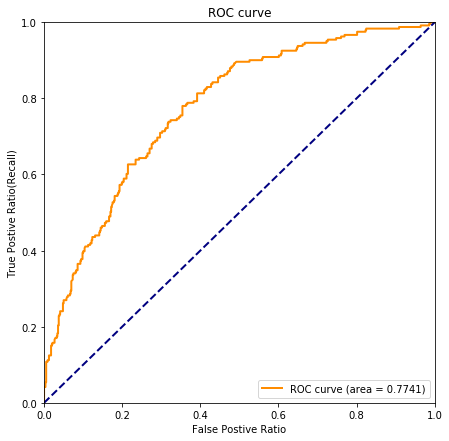

In [74]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Postive Ratio')
plt.ylabel('True Postive Ratio(Recall)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

## 6. 결정경계

In [75]:
for i in np.arange(0, 1, 0.1):
    train_pred['y_pred'] = 0
    train_pred.loc[train_pred['probs'] > i, 'y_pred'] = 1
    acc = round(accuracy_score(train_pred['class'], train_pred['y_pred']), 4)
    print("Threshold", round(i,1), "Train accuracy:",acc)

Threshold 0.0 Train accuracy: 0.3012
Threshold 0.1 Train accuracy: 0.4625
Threshold 0.2 Train accuracy: 0.63
Threshold 0.3 Train accuracy: 0.6975
Threshold 0.4 Train accuracy: 0.735
Threshold 0.5 Train accuracy: 0.7438
Threshold 0.6 Train accuracy: 0.74
Threshold 0.7 Train accuracy: 0.7275
Threshold 0.8 Train accuracy: 0.715
Threshold 0.9 Train accuracy: 0.7


In [76]:
for i in np.arange(0, 1, 0.1):
    test_pred['y_pred'] = 0
    test_pred.loc[test_pred['probs'] > i, 'y_pred'] = 1
    acc = round(accuracy_score(test_pred['class'], test_pred['y_pred']), 4)
    print("Threshold", round(i,1), "Test accuracy:",acc)

Threshold 0.0 Test accuracy: 0.295
Threshold 0.1 Test accuracy: 0.455
Threshold 0.2 Test accuracy: 0.625
Threshold 0.3 Test accuracy: 0.675
Threshold 0.4 Test accuracy: 0.725
Threshold 0.5 Test accuracy: 0.735
Threshold 0.6 Test accuracy: 0.735
Threshold 0.7 Test accuracy: 0.72
Threshold 0.8 Test accuracy: 0.705
Threshold 0.9 Test accuracy: 0.71


In [77]:
# Test prediction
test_pred = pd.DataFrame({
    'probs': drop_logistic_model.predict(sm.add_constant(test_x.drop(unnecesarries, axis=1))),
    'class': test_y
})

test_pred['y_pred'] = 0
test_pred.loc[test_pred['probs'] > 0.4, 'y_pred'] = 1

In [78]:
print('Test Confusion matrix:')
display(pd.crosstab(test_pred['y_pred'], test_pred['class'], rownames=['Predict'], colnames=['Actual'], margins=True))

Test Confusion matrix:


Actual,0,1,All
Predict,,,
0,106,20,126
1,35,39,74
All,141,59,200
